In [17]:
import sys

sys.path.append('../common')

from data_reading import*

import matplotlib.pyplot as plt
from linear_classifier import *

from random import randrange
import time

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
plt.rcParams['image.interpolation'] = 'bicubic'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
data_obj = public_datasets(False)

x_train, y_train, x_test, y_test = data_obj.load_cifar_data(False)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


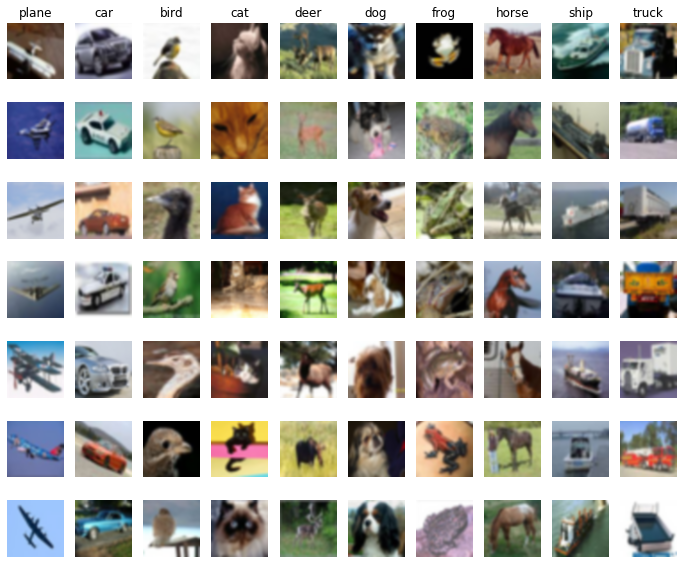

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train==y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
            
plt.show()

In [6]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training+num_validation)
x_val = x_train[mask]
y_val = y_train[mask]
print(x_val.shape, y_val.shape)

mask = range(num_training)
X_train = x_train[mask]
Y_train = y_train[mask]
print(X_train.shape, Y_train.shape)

mask = np.random.choice(num_training, num_dev, replace=False)
x_dev = x_train[mask]
y_dev = y_train[mask]
print(x_dev.shape, y_dev.shape)

mask = range(num_test)
X_test = x_test[mask]
Y_test = y_test[mask]
print(X_test.shape, Y_test.shape)

(1000, 32, 32, 3) (1000, 1)
(49000, 32, 32, 3) (49000, 1)
(500, 32, 32, 3) (500, 1)
(1000, 32, 32, 3) (1000, 1)


In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

print(x_train.shape, x_val.shape, x_dev.shape, x_test.shape)

(50000, 32, 32, 3) (1000, 3072) (500, 3072) (10000, 3072)


[0.51232    0.53326327 0.5195076  0.5100241  0.53078014 0.5166873
 0.51357174 0.5338977  0.5195207  0.515628  ]


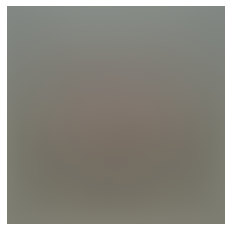

In [8]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape(32, 32, 3))
plt.axis('off')
plt.show()

In [9]:
#subtract mean image
X_train -= mean_image
x_val -= mean_image
x_dev -= mean_image
x_test -= mean_image

#biase trick (augmenting bias)

X_train_aug = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
x_val_aug = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
x_dev_aug = np.hstack([x_dev, np.ones((x_dev.shape[0], 1))])
x_test_aug = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

print(X_train_aug.shape, x_val_aug.shape, x_dev_aug.shape, x_test_aug.shape)

(49000, 3073) (1000, 3073) (500, 3073) (10000, 3073)


In [10]:
w = np.random.randn(X_train_aug.shape[1], 10)*0.0001 #generate random weights matrix with small numbers
loss, gradients = svm_loss_naive(w, x_dev_aug, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.002926


In [11]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])
        
        oldval = x[ix]
        x[ix] = oldval + h
        fxph = f(x)
        x[ix] = oldval - h
        fxmh = f(x)
        x[ix] = oldval
        
        grad_numerical = (fxph - fxmh) / (2*h)
        grad_analytic = analytic_grad[ix]
        rel_err = (abs(grad_numerical - grad_analytic)/ (abs(grad_numerical)+abs(grad_analytic)))
        
        print('numerical: %f analytic: %f, relative error: %f'%(grad_numerical, grad_analytic, rel_err))

In [12]:
loss, grad = svm_loss_naive(w, x_dev_aug, y_dev, 0.0)
f = lambda w: svm_loss_naive(w, x_dev_aug, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, w, grad)

numerical: 0.035955 analytic: 0.002902, relative error: 0.850609
numerical: 0.015285 analytic: 0.002327, relative error: 0.735718
numerical: 0.005960 analytic: 0.000569, relative error: 0.825585
numerical: -0.025784 analytic: -0.011358, relative error: 0.388412
numerical: -0.057772 analytic: -0.007166, relative error: 0.779288
numerical: 0.022033 analytic: -0.006243, relative error: 1.000000
numerical: 0.110244 analytic: 0.013996, relative error: 0.774699
numerical: 0.011742 analytic: -0.002469, relative error: 1.000000
numerical: -0.044169 analytic: -0.009083, relative error: 0.658861
numerical: 0.096884 analytic: 0.007760, relative error: 0.851694


In [13]:
loss, grad = svm_loss_naive(w, x_dev_aug, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, x_dev_aug, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, w, grad)

numerical: -0.184845 analytic: -0.019368, relative error: 0.810312
numerical: -0.018413 analytic: -0.016074, relative error: 0.067812
numerical: 0.064313 analytic: 0.006104, relative error: 0.826634
numerical: 0.073234 analytic: 0.020202, relative error: 0.567577
numerical: -0.082006 analytic: -0.018864, relative error: 0.625973
numerical: -0.168970 analytic: -0.025344, relative error: 0.739143
numerical: 0.026509 analytic: 0.001524, relative error: 0.891295
numerical: 0.044034 analytic: -0.003594, relative error: 1.000000
numerical: -0.021193 analytic: -0.015446, relative error: 0.156848
numerical: -0.105620 analytic: 0.005463, relative error: 1.000000


In [18]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(w, x_dev_aug, y_dev, 5e1)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss, grad = svm_loss_vectorized(w, x_dev_aug, y_dev, 5e1)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss, toc - tic))

difference = np.linalg.norm(grad_naive - grad, ord='fro')
print('difference: %f' % difference)

Naive loss: 9.018478e+00 computed in 0.162158s
vectorized loss: 1.555176e-02 computed in 0.002024s


In [17]:
num_classes = w.shape[1]
num_train = x_dev_aug.shape[0]
print(num_classes, num_train)

scores = x_dev_aug.dot(w)
print(x_dev_aug.shape, w.shape, scores.shape, y_dev.shape)

margin = scores[np.arange(num_train), y_dev.squeeze()].reshape(num_train, 1)
print(margin.shape)
#print(scores[np.arange(num_train), y_dev])
#print(scores[y_dev])

10 500
(500, 3073) (3073, 10) (500, 10) (500, 1)
(500, 1)
